<IMG SRC="https://raw.githubusercontent.com/pastas/pastas/master/doc/_static/logo.png" WIDTH=250 ALIGN="right">
    
# Example 2: Analysis of groundwater monitoring networks using Pastas

This notebook is supplementary material to the following paper submitted to Groundwater:

*R.A. Collenteur, M. Bakker, R. Calje, S. Klop, F. Schaars, (2019) Pastas: open source software for the analysis of groundwater time series, Manuscript under review.*

In this second example, it is demonstrated how scripts can be used to analyze a large number of time series. Consider a pumping well field surrounded by a number of observations wells. The pumping wells are screened in the middle aquifer of a three-aquifer system. The objective is to estimate the drawdown caused by the groundwater pumping in each observation well.


## 1. Import the packages

In [1]:
# Import the packages
import pandas as pd
import pastas as ps
import numpy as np
import os

import matplotlib.pyplot as plt

%matplotlib inline

# This notebook has been developed using Pastas version 0.9.9 and Python 3.7
print("Pastas version: {}".format(ps.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("Python version: {}".format(os.sys.version))

ps.set_log_level("ERROR")

Pastas version: 0.12.0b
Pandas version: 0.24.2
Numpy version: 1.15.4
Python version: 3.7.2 (default, Dec 29 2018, 00:00:04) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## 2. Importing the time series
In this codeblock the time series are imported and collected into a Pastas Project. `This Project` is a Pastas Class that contains methods that aim to ease the work when dealing with multiple time series. The following time series are imported:

- 44 time series with head observations [m] from the monitoring network;
- precipitation [m/d] from KNMI station Oudenbosch;
- potential evaporation [m/d] from KNMI station de Bilt;
- Total pumping rate [m3/d] from well field Seppe.

In [2]:
# Start an Pastas Project
pr = ps.Project(name="Example2")

# Load a metadata-file with xy-coordinates from the groundwater heads
metadata = pd.read_csv("data/metadata_heads.csv", index_col=0)

# Add the groundwater head observations to the database
for fname in os.listdir("./data/heads/"):
    fname = os.path.join("./data/heads/", fname)
    obs = pd.read_csv(fname, parse_dates=True, index_col=0, squeeze=True)
    meta = metadata.loc[obs.name].to_dict()
    pr.add_series(obs, kind="oseries", metadata=meta)

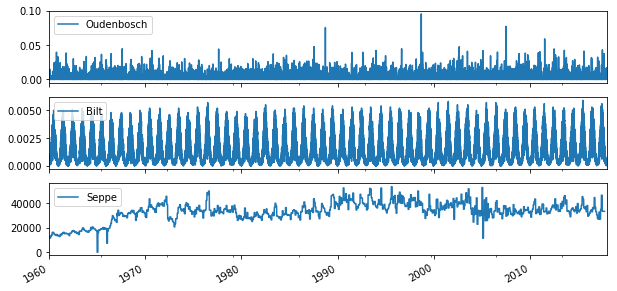

In [3]:
# Load a metadata-file with xy-coordinates from the explanatory variables
metadata = pd.read_csv("data/metadata_stresses.csv", index_col=0)

# Import the precipitation time series
rain = pd.read_csv("data/rain.csv", parse_dates=True, index_col=0, squeeze=True)
pr.add_series(rain, kind="prec", metadata=metadata.loc[rain.name].to_dict())

# Import the evaporation time series
evap = pd.read_csv("data/evap.csv", parse_dates=True, index_col=0, squeeze=True)
pr.add_series(evap, kind="evap", metadata=metadata.loc["Bilt"].to_dict())

# Import the well abstraction time series 
well = pd.read_csv("data/well.csv", parse_dates=True, index_col=0, squeeze=True)
pr.add_series(well, kind="well", metadata=metadata.loc[well.name].to_dict())

# Use the plotting method of the Pastas Project to plot the stresses
pr.plots.stresses(["prec", "evap", "well"], cols=1, figsize=(10,5), sharex=True);
plt.xlim("1960", "2018");

## 3/4/5. Creating and optimizing the Time Series Model

For each time series of groundwater head observations a TFN model is constructed with the following model components:
- A Constant
- A NoiseModel
- A RechargeModel object to simulate the effect of recharge
- A StressModel object to simulate the effect of groundwater extraction


***Calibrating all models can take a couple of minutes!!***

In [4]:
# Create folder to save the model figures
mlpath = "models"
if not os.path.exists(mlpath):
    os.mkdir(mlpath)

# Choose the calibration period
tmin = "1970"
tmax = "2017-09"

num = 0

for oseries in pr.oseries.index:
    # Create a Model for each time series and add a StressModel2 for the recharge
    ml = pr.add_model(oseries)

    # Add the RechargeModel to simulate the effect of rainfall and evaporation
    rm = ps.RechargeModel(rain, evap, rfunc=ps.Gamma, name="recharge")
    ml.add_stressmodel(rm)
    
    # Add a StressModel to simulate the effect of the groundwater extractions
    sm = ps.StressModel(well, rfunc=ps.Hantush, name="well", settings="well", up=False)
    ml.add_stressmodel(sm)

    # Since we are dealing with different measurement frequencies for the head, 
    # change the initial parameter for the noise model a little.
#     alpha_init = ml.oseries.series.index.to_series().diff() / pd.Timedelta(1, 'd')
#     ml.set_initial("noise_alpha", alpha_init.mean())
    ml.set_initial("noise_alpha", 3)
    
    # Estimate the model parameters
    ml.solve(tmin=tmin, tmax=tmax, report=False, solver=ps.LmfitSolve)

    # Check if the estimated effect of the groundwater extraction is significant.
    # If not, delete the stressmodel and calibrate the model again.
    gain, stderr = ml.parameters.loc["well_A", ["optimal", "stderr"]]
    if 1.96 * stderr > -gain:
        num += 1
        ml.del_stressmodel("well")
        ml.solve(tmin=tmin, tmax=tmax, report=False)
        
    # Plot the results and store the plot
    ml.plots.results()
    path = os.path.join(mlpath, ml.name + ".png")
    plt.savefig(path, bbox_inches="tight")
    plt.close()
    
print("The number of models where the well is dropped from the model is:", str(num))

/Applications/anaconda3/envs/py37_pastas/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=734149.5, right=734149.5
  ax.set_xlim(left, right)


The number of models where the well is dropped from the model is: 9


# Make plots for publication
In the next codeblocks the Figures used in the Pastas paper are created. The first codeblock sets the matplotlib parameters to obtain publication-quality figures. The following figures are created:

- Figure of the drawdown estimated for each observations well; 
- Figure of the decomposition of the different contributions;
- Figure of the pumping rate of the well field.

In [5]:
params = {
   'axes.labelsize': 18,
   'axes.axisbelow': True,
   'font.size': 16,
   'font.family': 'serif',
   'legend.fontsize': 16,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16,
   'text.usetex': False,
   'figure.figsize': [8.2, 5],
   'lines.linewidth' : 2,
   }
plt.rcParams.update(params)

# Save figures or not
savefig = True
figpath = "figures"
if not os.path.exists(figpath):
    os.mkdir(figpath)

### Figure of the drawdown estimated for each observations well

In [27]:
try:
    from timml import ModelMaq, Well
    plot_timml = True
    # Values from REGIS II v2.2 (Site id B49F0240)
    z = [9, -25, -83, -115, -190] # Reference to NAP
    kv = np.array([1e-3, 5e-3]) # Min-Max of Vertical hydraulic conductivity for both leaky layer
    D1 = z[0]-z[1] # Estimated thickness of leaky layer
    c1 = D1/kv # Estimated resistance
    D2 = z[2] - z[3]
    c2 = D2 / kv

    kh1 = np.array([1e0, 2.5e0]) # Min-Max of Horizontal hydraulic conductivity for aquifer 1
    kh2 = np.array([1e1, 2.5e1]) # Min-Max of Horizontal hydraulic conductivity for aquifer 2

    mlm = ModelMaq(kaq=[kh1.mean(), 35], z=z, c=[c1.max(), c2.mean()], \
                  topboundary='semi', hstar=0)
    w = Well(mlm, 0, 0, 34791, layers=1)
    mlm.solve()
    x = np.linspace(100, 5000, 100)
    h = mlm.headalongline(x, 0)
except:
    plot_timml = False

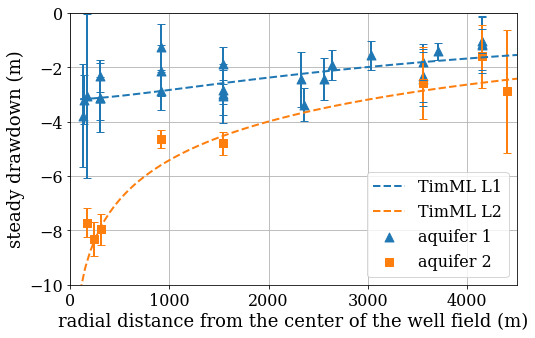

In [28]:
# Get the parameters and distances to plot
param_A = pr.get_parameters(["well_A"])*well.loc["2007":].mean()
#param_A.fillna(0.0, inplace=True)
distances = pr.get_distances(oseries=param_A.index, kind="well").squeeze()

# Select model per aquifer
shallow = pr.oseries.z.loc[(pr.oseries.z<96)].index
aquifer = pr.oseries.z.loc[(pr.oseries.z<186) & (pr.oseries.z>96)].index
deep = pr.oseries.z.loc[pr.oseries.z>186].index

# Make the plot
fig = plt.figure(figsize=(8,5))
plt.grid(zorder=-10)

display_error_bars = True

if display_error_bars:
    std = pr.get_parameters(["well_A"], param_value="stderr")*well.loc["2007":].mean()
    plt.errorbar(distances[shallow], param_A[shallow], yerr=1.96*std[shallow], linestyle="", 
                 elinewidth=2, marker="", markersize=10, capsize=4)
    plt.errorbar(distances[aquifer], param_A[aquifer], yerr=1.96*std[aquifer], linestyle="", 
                 elinewidth=2, marker="", capsize=4)   
#     plt.errorbar(distances[deep], param_A[deep], yerr=1.96*std[deep], linestyle="", 
#                  elinewidth=2, marker="", capsize=4)
    
plt.scatter(distances[shallow], param_A[shallow], marker="^", s=80)
plt.scatter(distances[aquifer], param_A[aquifer], marker="s", s=80)
#plt.scatter(distances[deep], param_A[deep], marker="v", s=100)

# Plot two-layer TimML model for comparison
if plot_timml:
    plt.plot(x, h[0], color="C0", linestyle="--" )
    plt.plot(x, h[1], color="C1", linestyle="--" )
    legend = ["TimML L1", "TimML L2", "aquifer 1", "aquifer 2"]
else:
    legend = ["aquifer 1", "aquifer 2"]

plt.ylabel("steady drawdown (m)")
plt.xlabel("radial distance from the center of the well field (m)")
plt.xlim(0, 4501)
plt.ylim(-10,0)
plt.legend(legend, loc=4)

if savefig:
    path = os.path.join(figpath, "drawdown.eps")
    plt.savefig(path, bbox_inches="tight", dpi=300)

### Example figure of a TFN model 

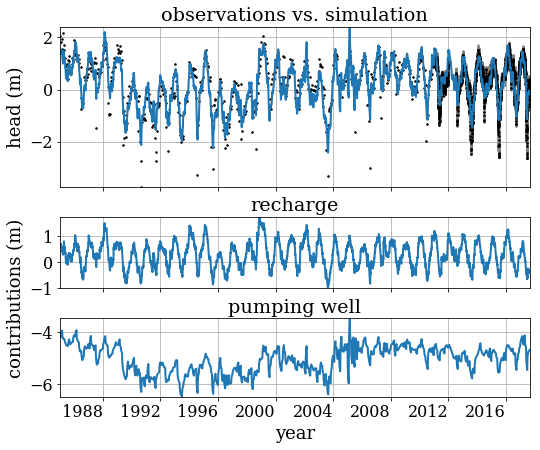

In [9]:
# Select a model to plot
ml = pr.models["B49F0232_5"]

# Create the figure
[ax1, ax2, ax3] = ml.plots.decomposition(split=False, figsize=(7,6), ytick_base=1, tmin="1985")
plt.xticks(rotation=0)
ax1.set_yticks([2, 0, -2])
ax1.set_ylabel("head (m)")
ax1.legend().set_visible(False)
ax3.set_yticks([-4, -6])
ax2.set_ylabel("contributions (m)                ") # Little trick to get the label right
ax3.set_xlabel("year")
ax3.set_title("pumping well")

if savefig:
    path = os.path.join(figpath, ml.name + ".eps")
    plt.savefig(path, bbox_inches="tight", dpi=300)

### Figure of the pumping rate of the well field

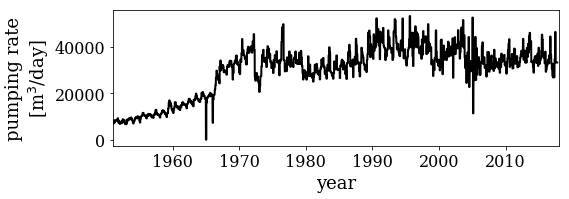

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,2.5), sharex=True)
ax.plot(well, color="k")
ax.set_ylabel("pumping rate\n[m$^3$/day]")
ax.set_xlabel("year")
ax.set_xlim("1951", "2018")

if savefig:
    path = os.path.join(figpath, "extraction.eps")
    plt.savefig(path, bbox_inches="tight", dpi=300)